#### TODO
- implement split point between different episode

## Import Packages

In [1]:
from mushroom_rl.core import Core, Agent
from loco_mujoco import LocoEnv
import mujoco
import numpy as np
from numpy import linalg as LA
from operator import itemgetter 
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

## Load Agent from checkpoint
Sometimes the agent would fumble or the heel strike detection is not working perfectly, so we set a cycle_length_cutoff that sets the minimum length of a complete cycle. If a cycle is shorter than this, it will get discarded

In [2]:
dataset_env = LocoEnv.make('HumanoidTorque.walk', dataset_type='perfect', random_start=False)
trained_env = LocoEnv.make("HumanoidTorque.walk")
dummy_env = LocoEnv.make("HumanoidTorqueExo.walk")
exo_env = LocoEnv.make("HumanoidTorqueExo.walk", enable_exo_control=True, delay=120, scale=0.2)

agent = Agent.load("../../../humanoidTorque-testrun/logs/loco_mujoco_evalution_2024-05-07_22-35-44/env_id___HumanoidTorque.walk/0/agent_epoch_95_J_986.666168.msh")

Dummy Exo
Simple Exo Control: Exo_torque(t) = Hip_torque(t - 120 ms) * 0.2


## Evaluate agent and collect data
Data contains
- dataset: observations and actions
- ground reaction force (GRF)
- heel strikes: Typically the start and end of a gait cycle is defined by heel strike, here we use left foot heel strike

### Dataset

In [ ]:
dataset_heel_strikes, dataset_grfs = dataset_env.play_trajectory(n_episodes=5, get_dataset=True, record=False)

In [12]:
len(dataset_grfs)

5000

In [ ]:
new_dataset_heel_strikes = []
for i, heel_strikes in enumerate(dataset_heel_strikes):
    heel_strikes = [heel_strike+i*1000 for heel_strike in heel_strikes]
    new_dataset_heel_strikes.append(heel_strikes)

dataset_heel_strikes = []
for heel_strikes in new_dataset_heel_strikes:
    dataset_heel_strikes.extend(heel_strikes)

In [19]:
len(dataset_heel_strikes)

52

In [4]:
dataset = np.load('..\..\loco_mujoco\datasets\humanoids\perfect\humanoid_torque_walk\perfect_expert_dataset_det.npz')

In [23]:
dataset = (dataset['states'][:5000], dataset['actions'][:5000])

### No exo

In [5]:
def trained_get_heelstrike_and_grf(sample):
    global trained_step
    global trained_l_foot_contact
    global trained_heel_strikes
    global trained_grfs

    # heel strike
    contact_group = []
    for coni in range(trained_env._data.ncon):
        con = trained_env._data.contact[coni]
        geom1 = mujoco.mj_id2name(trained_env._model, mujoco.mjtObj.mjOBJ_GEOM, con.geom1)
        geom2 = mujoco.mj_id2name(trained_env._model, mujoco.mjtObj.mjOBJ_GEOM, con.geom2)
        contact_group.append(set([geom1, geom2]))

    if set(['floor', 'foot_box_l']) in contact_group:
        if not trained_l_foot_contact:
            trained_l_foot_contact = True
            trained_heel_strikes.append(trained_step)
    else:
        trained_l_foot_contact = False

    # grf
    trained_l_grf = trained_env._get_ground_forces()[-3:]
    trained_grfs.append(trained_l_grf)
        
    trained_step +=1

In [6]:
trained_step = 0
trained_l_foot_contact = False
trained_heel_strikes = []
trained_grfs = []
core = Core(agent, trained_env, callback_step=trained_get_heelstrike_and_grf)
trained_dataset = core.evaluate(n_episodes=5, render=True, record=True)

### Dummy env

In [5]:
def dummy_get_heelstrike_and_grf(sample):
    global dummy_step
    global dummy_l_foot_contact
    global dummy_heel_strikes
    global dummy_grfs

    # heel strike
    contact_group = []
    for coni in range(dummy_env._data.ncon):
        con = dummy_env._data.contact[coni]
        geom1 = mujoco.mj_id2name(dummy_env._model, mujoco.mjtObj.mjOBJ_GEOM, con.geom1)
        geom2 = mujoco.mj_id2name(dummy_env._model, mujoco.mjtObj.mjOBJ_GEOM, con.geom2)
        contact_group.append(set([geom1, geom2]))

    if set(['floor', 'foot_box_l']) in contact_group:
        if not dummy_l_foot_contact:
            dummy_l_foot_contact = True
            dummy_heel_strikes.append(dummy_step)
    else:
        dummy_l_foot_contact = False

    # grf
    dummy_l_grf = dummy_env._get_ground_forces()[-3:]
    dummy_grfs.append(dummy_l_grf)
        
    dummy_step +=1

In [ ]:
dummy_step = 0
dummy_l_foot_contact = False
dummy_heel_strikes = []
dummy_grfs = []
core = Core(agent, dummy_env, callback_step=dummy_get_heelstrike_and_grf)
dummy_dataset = core.evaluate(n_episodes=5, render=True, record=False)

In [9]:
len(dummy_dataset)

5000

In [10]:
def exo_get_heelstrike_and_grf_and_exotorque(sample):
    global exo_step
    global exo_l_foot_contact
    global exo_heel_strikes
    global exo_grfs
    global exo_torques

    # heel strike
    contact_group = []
    for coni in range(exo_env._data.ncon):
        con = exo_env._data.contact[coni]
        geom1 = mujoco.mj_id2name(exo_env._model, mujoco.mjtObj.mjOBJ_GEOM, con.geom1)
        geom2 = mujoco.mj_id2name(exo_env._model, mujoco.mjtObj.mjOBJ_GEOM, con.geom2)
        contact_group.append(set([geom1, geom2]))

    if set(['floor', 'foot_box_l']) in contact_group:
        if not exo_l_foot_contact:
            exo_l_foot_contact = True
            exo_heel_strikes.append(exo_step)
    else:
        exo_l_foot_contact = False

    # grf
    exo_l_grf = exo_env._get_ground_forces()[-3:]
    exo_grfs.append(exo_l_grf)

    l_exo_torque = exo_env.exo_torque[1]
    exo_torques.append(l_exo_torque)
        
    exo_step +=1

In [11]:
exo_step = 0
exo_l_foot_contact = False
exo_heel_strikes = []
exo_grfs = []
exo_torques = []
core = Core(agent, exo_env, callback_step=exo_get_heelstrike_and_grf_and_exotorque)
exo_dataset = core.evaluate(n_episodes=5, render=True, record=True)

## Set indices of features in interested 
check here https://github.com/robfiras/loco-mujoco/blob/master/loco_mujoco/environments/humanoids/humanoids.py

In [26]:
obs_keys = dict(
    q_hip_flexion_l=9,
    q_knee_angle_l=12,
    q_ankle_angle_l=13,
    dq_hip_flexion_l=28,
    dq_knee_angle_l=31,
    dq_ankle_angle_l=32,
)
act_keys = dict(
    mot_hip_flexion_l=8,
    mot_knee_angle_l=11,
    mot_ankle_angle_l=12,
)

## Reconstruct a new dataset with only features in interested
Format: (n_steps X obs(6)+act(3)+grf(3)+exo_torque(1))

In [27]:
processed_dataset = []
for i in range(5000):
    data = []
    for j in obs_keys.values():
        data.append(dataset[0][i][j])
    for k in act_keys.values():
        data.append(dataset[1][i][k])
    data.extend(dataset_grfs[i])

    processed_dataset.append(np.array(data))

processed_dataset = np.array(processed_dataset)
print(processed_dataset.shape)

(5000, 12)


In [28]:
processed_trained_dataset = []
# format: obs(6), act(3), grf(3)
for i in range(len(trained_dataset)):
    data = []
    for j in obs_keys.values():
        data.append(trained_dataset[i][0][j])
    for k in act_keys.values():
        data.append(trained_dataset[i][1][k])
    data.extend(trained_grfs[i])
    
    processed_trained_dataset.append(np.array(data))

processed_trained_dataset = np.array(processed_trained_dataset)
print(processed_trained_dataset.shape)

(5000, 12)


In [29]:
processed_dummy_dataset = []
# format: obs(6), act(3), grf(3)
for i in range(len(dummy_dataset)):
    data = []
    for j in obs_keys.values():
        data.append(dummy_dataset[i][0][j])
    for k in act_keys.values():
        data.append(dummy_dataset[i][1][k])
    data.extend(dummy_grfs[i])
    
    processed_dummy_dataset.append(np.array(data))

processed_dummy_dataset = np.array(processed_dummy_dataset)
print(processed_dummy_dataset.shape)

(5000, 12)


In [30]:
processed_exo_dataset = []
# format: obs(6), act(3), grf(3), exo_torque(1)
for i in range(len(exo_dataset)):
    data = []
    for j in obs_keys.values():
        data.append(exo_dataset[i][0][j])
    for k in act_keys.values():
        data.append(exo_dataset[i][1][k])
    data.extend(exo_grfs[i])
    data.append(exo_torques[i])
    
    processed_exo_dataset.append(np.array(data))

processed_exo_dataset = np.array(processed_exo_dataset)
print(processed_exo_dataset.shape)

(4291, 13)


## Filter out bad cycle based on cycle_length_cutoff

In [89]:
cycle_length_cutoff = 90

In [90]:
dataset_cycles = []
dataset_cycle_lengths = np.diff(dataset_heel_strikes)
for i, dataset_cycle_length in enumerate(dataset_cycle_lengths):
    if dataset_cycle_length > cycle_length_cutoff:
        dataset_cycles.append(processed_dataset[dataset_heel_strikes[i]:dataset_heel_strikes[i+1]])
print(f'Number of recorded dataset_cycle: {len(dataset_cycle_lengths)}')
print(f'Cycle length cutff: {cycle_length_cutoff}')
print(f'Number of effective dataset_cycle: {len(dataset_cycles)}')

Number of recorded dataset_cycle: 51
Cycle length cutff: 90
Number of effective dataset_cycle: 43


In [91]:
trained_cycles = []
trained_cycle_lengths = np.diff(trained_heel_strikes)
for i, trained_cycle_length in enumerate(trained_cycle_lengths):
    if trained_cycle_length > cycle_length_cutoff:
        trained_cycles.append(processed_trained_dataset[trained_heel_strikes[i]:trained_heel_strikes[i+1]])
print(f'Number of recorded trained_cycle: {len(trained_cycle_lengths)}')
print(f'Cycle length cutff: {cycle_length_cutoff}')
print(f'Number of effective trained_cycle: {len(trained_cycles)}')

Number of recorded trained_cycle: 49
Cycle length cutff: 90
Number of effective trained_cycle: 42


In [92]:
dummy_cycles = []
dummy_cycle_lengths = np.diff(dummy_heel_strikes)
for i, dummy_cycle_length in enumerate(dummy_cycle_lengths):
    if dummy_cycle_length > cycle_length_cutoff:
        dummy_cycles.append(processed_dummy_dataset[dummy_heel_strikes[i]:dummy_heel_strikes[i+1]])
print(f'Number of recorded dummy_cycle: {len(dummy_cycle_lengths)}')
print(f'Cycle length cutff: {cycle_length_cutoff}')
print(f'Number of effective dummy_cycle: {len(dummy_cycles)}')

Number of recorded dummy_cycle: 47
Cycle length cutff: 90
Number of effective dummy_cycle: 42


In [93]:
exo_cycles = []
exo_cycle_lengths = np.diff(exo_heel_strikes)
for i, exo_cycle_length in enumerate(exo_cycle_lengths):
    if exo_cycle_length > cycle_length_cutoff:
        exo_cycles.append(processed_exo_dataset[exo_heel_strikes[i]:exo_heel_strikes[i+1]])
print(f'Number of recorded exo_cycle: {len(exo_cycle_lengths)}')
print(f'Cycle length cutff: {cycle_length_cutoff}')
print(f'Number of effective exo_cycle: {len(exo_cycles)}')

Number of recorded exo_cycle: 63
Cycle length cutff: 90
Number of effective exo_cycle: 25


## Sample 20 cycles and resample all cycles to the mean length

In [94]:
n_sample = 20
rng = np.random.default_rng()
idxs = np.arange(len(dataset_cycles))
rng.shuffle(idxs, axis=0)

dataset_sampled_cycles = itemgetter(*idxs[:n_sample])(dataset_cycles)
dataset_sampled_cycles_lengths = [len(cycle) for cycle in dataset_sampled_cycles]
dataset_mean_length = round(np.mean(dataset_sampled_cycles_lengths))
assert len(dataset_sampled_cycles) == n_sample
print(f'Number of sampled cycle: {n_sample}')
print(f'Env Mean length: {dataset_mean_length}')

Number of sampled cycle: 20
Env Mean length: 106


In [96]:
n_sample = 20
rng = np.random.default_rng()
idxs = np.arange(len(trained_cycles))
rng.shuffle(idxs, axis=0)

trained_sampled_cycles = itemgetter(*idxs[:n_sample])(trained_cycles)
trained_sampled_cycles_lengths = [len(cycle) for cycle in trained_sampled_cycles]
trained_mean_length = round(np.mean(trained_sampled_cycles_lengths))
assert len(trained_sampled_cycles) == n_sample
print(f'Number of sampled cycle: {n_sample}')
print(f'Env Mean length: {trained_mean_length}')

Number of sampled cycle: 20
Env Mean length: 112


In [98]:
n_sample = 20
rng = np.random.default_rng()
idxs = np.arange(len(dummy_cycles))
rng.shuffle(idxs, axis=0)

dummy_sampled_cycles = itemgetter(*idxs[:n_sample])(dummy_cycles)
dummy_sampled_cycles_lengths = [len(cycle) for cycle in dummy_sampled_cycles]
dummy_mean_length = round(np.mean(dummy_sampled_cycles_lengths))
assert len(dummy_sampled_cycles) == n_sample
print(f'Number of sampled cycle: {n_sample}')
print(f'Dummy Mean length: {dummy_mean_length}')

Number of sampled cycle: 20
Dummy Mean length: 116


In [100]:
n_sample = 20
rng = np.random.default_rng()
idxs = np.arange(len(exo_cycles))
rng.shuffle(idxs, axis=0)

exo_sampled_cycles = itemgetter(*idxs[:n_sample])(exo_cycles)
exo_sampled_cycles_lengths = [len(cycle) for cycle in exo_sampled_cycles]
exo_mean_length = round(np.mean(exo_sampled_cycles_lengths))
assert len(exo_sampled_cycles) == n_sample
print(f'Number of sampled cycle: {n_sample}')
print(f'Exo Mean length: {exo_mean_length}')

Number of sampled cycle: 20
Exo Mean length: 115


In [103]:
(115 + 116 + 112 + 106)/4

112.25

In [104]:
mean_length = 112

In [105]:
dataset_interpolated_cycles = []
for cycle in dataset_sampled_cycles:
    length = len(cycle)
    x = np.linspace(0, length-1, num=length)
    xnew = np.linspace(0, length-1, num=mean_length)
    
    new_cycle = []
    for i in range(cycle.shape[1]):
        y = cycle[:, i]
        spl = CubicSpline(x, y)
        new_cycle.append(spl(xnew))
    new_cycle = np.array(new_cycle)
    dataset_interpolated_cycles.append(new_cycle)

dataset_interpolated_cycles = np.array(dataset_interpolated_cycles)
dataset_interpolated_cycles = np.swapaxes(dataset_interpolated_cycles, 0, 1)
print(dataset_interpolated_cycles.shape)

(12, 20, 112)


In [106]:
trained_interpolated_cycles = []
for cycle in trained_sampled_cycles:
    length = len(cycle)
    x = np.linspace(0, length-1, num=length)
    xnew = np.linspace(0, length-1, num=mean_length)
    
    new_cycle = []
    for i in range(cycle.shape[1]):
        y = cycle[:, i]
        spl = CubicSpline(x, y)
        new_cycle.append(spl(xnew))
    new_cycle = np.array(new_cycle)
    trained_interpolated_cycles.append(new_cycle)

trained_interpolated_cycles = np.array(trained_interpolated_cycles)
trained_interpolated_cycles = np.swapaxes(trained_interpolated_cycles, 0, 1)
print(trained_interpolated_cycles.shape)

(12, 20, 112)


In [107]:
dummy_interpolated_cycles = []
for cycle in dummy_sampled_cycles:
    length = len(cycle)
    x = np.linspace(0, length-1, num=length)
    xnew = np.linspace(0, length-1, num=mean_length)
    
    new_cycle = []
    for i in range(cycle.shape[1]):
        y = cycle[:, i]
        spl = CubicSpline(x, y)
        new_cycle.append(spl(xnew))
    new_cycle = np.array(new_cycle)
    dummy_interpolated_cycles.append(new_cycle)

dummy_interpolated_cycles = np.array(dummy_interpolated_cycles)
dummy_interpolated_cycles = np.swapaxes(dummy_interpolated_cycles, 0, 1)
print(dummy_interpolated_cycles.shape)

(12, 20, 112)


In [108]:
exo_interpolated_cycles = []
for cycle in exo_sampled_cycles:
    length = len(cycle)
    x = np.linspace(0, length-1, num=length)
    xnew = np.linspace(0, length-1, num=mean_length)
    
    new_cycle = []
    for i in range(cycle.shape[1]):
        y = cycle[:, i]
        spl = CubicSpline(x, y)
        new_cycle.append(spl(xnew))
    new_cycle = np.array(new_cycle)
    exo_interpolated_cycles.append(new_cycle)

exo_interpolated_cycles = np.array(exo_interpolated_cycles)
exo_interpolated_cycles = np.swapaxes(exo_interpolated_cycles, 0, 1)
print(exo_interpolated_cycles.shape)

(13, 20, 112)


## Plot Gaits Function
Todo: support draw multiple gaits

In [138]:
def plot_gait(data_dict, mean_length, alpha=0.4, ylabel='Angle', title='test', save=False):
    idxs = np.linspace(0, 1, mean_length)*100
    
    fig, ax = plt.subplots(figsize=(10, 4), layout="constrained")

    for label, data in data_dict.items():   
        ax.plot(idxs,np.mean(data, axis=0), label=label)
        ax.fill_between(idxs, np.mean(data, axis=0) - np.std(data, axis=0), np.mean(data, axis=0) + np.std(data, axis=0), alpha=alpha)
    
    plt.xticks([0, 20, 40, 60, 80, 100])
    plt.xlim(0, 100)
    plt.xlabel("Gait Phase (%)")
    plt.ylabel(ylabel)
    ax.spines[['right', 'top']].set_visible(False)
    plt.axhline(y = 0, color = 'black', alpha=0.1)
    plt.title(title)
    plt.legend()
    if save:
        plt.savefig(f'{title}.png', dpi=300)
    else:
        plt.show()

## Plot Joint Angle

In [110]:
dataset_hip_angle = dataset_interpolated_cycles[0]
trained_hip_angle = trained_interpolated_cycles[0]
dummy_hip_angle = dummy_interpolated_cycles[0]
exo_hip_angle = exo_interpolated_cycles[0]

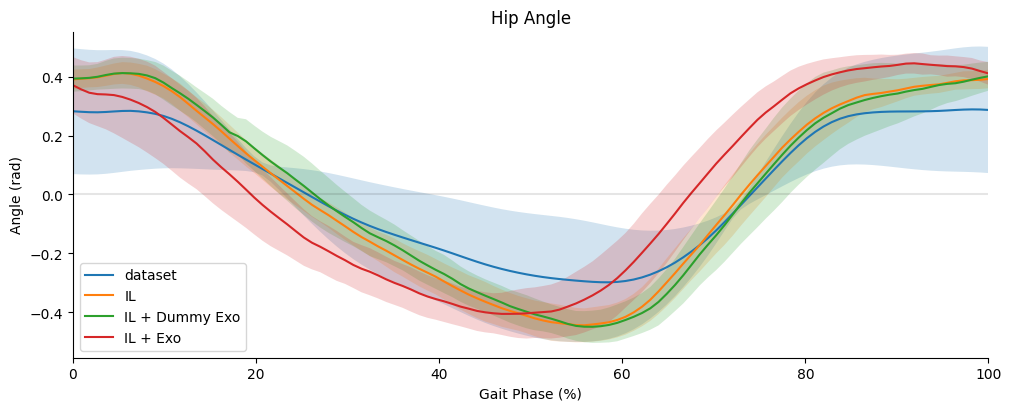

In [139]:
data_dict = {
    'dataset': dataset_hip_angle,
    'IL': trained_hip_angle,
    'IL + Dummy Exo': dummy_hip_angle,
    'IL + Exo': exo_hip_angle
}
plot_gait(data_dict, mean_length, ylabel='Angle (rad)', title='Hip Angle', alpha=0.2, save=True)

### Sign of some features needs to be adjust (e.g. knee)

In [112]:
dataset_knee_angle = dataset_interpolated_cycles[1]*-1
trained_knee_angle = trained_interpolated_cycles[1]*-1
dummy_knee_angle = dummy_interpolated_cycles[1]*-1
exo_knee_angle = exo_interpolated_cycles[1]*-1

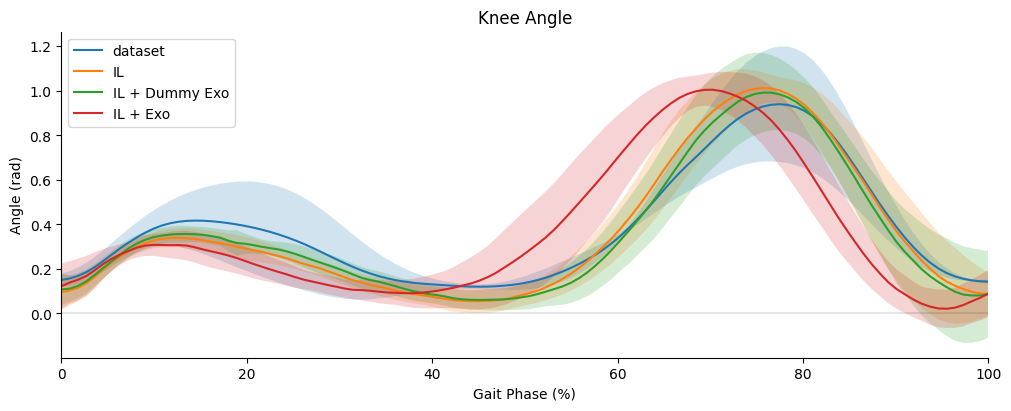

In [154]:
data_dict = {
    'dataset': dataset_knee_angle,
    'IL': trained_knee_angle,
    'IL + Dummy Exo': dummy_knee_angle,
    'IL + Exo': exo_knee_angle
}
plot_gait(data_dict, mean_length, ylabel='Angle (rad)', title='Knee Angle', alpha=0.2, save=True)

In [114]:
dataset_ankle_angle = dataset_interpolated_cycles[2]
trained_ankle_angle = trained_interpolated_cycles[2]
dummy_ankle_angle = dummy_interpolated_cycles[2]
exo_ankle_angle = exo_interpolated_cycles[2]

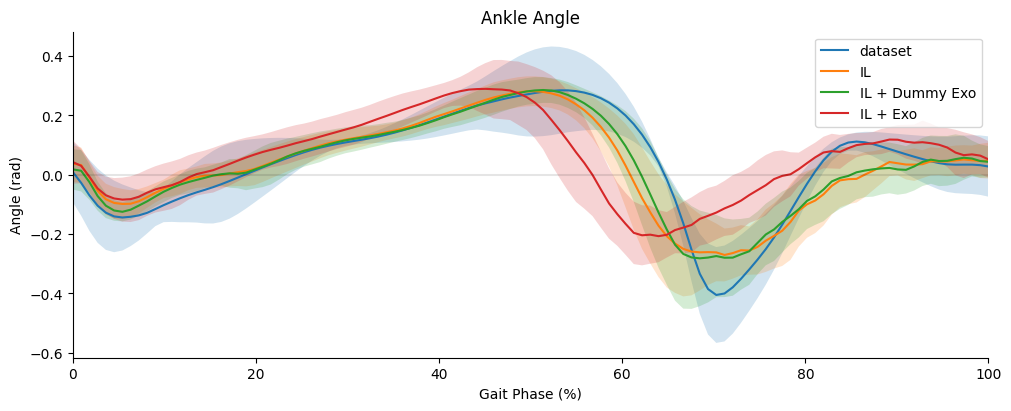

In [141]:
data_dict = {
    'dataset': dataset_ankle_angle,
    'IL': trained_ankle_angle,
    'IL + Dummy Exo': dummy_ankle_angle,
    'IL + Exo': exo_ankle_angle
}
plot_gait(data_dict, mean_length, ylabel='Angle (rad)', title='Ankle Angle', alpha=0.2, save=True)

## Plot Joint Torque

### Smoothing function since Torque vibrate too much

In [116]:
def smooth_1d(data, window_size=5):
    kernel = np.ones(window_size) / window_size
    length = len(data)
    
    smooth_data = np.convolve(data, kernel, 'valid')
    x = np.linspace(0, len(smooth_data)-1, num=len(smooth_data))
    xnew = np.linspace(0, len(smooth_data)-1, num=len(data))
    spl = CubicSpline(x, smooth_data)
    smooth_data = spl(xnew)
    return smooth_data

def smooth_2d(data, window_size=5):
    smooth_data = []
    for cycle in data:
        smooth_data.append(smooth_1d(cycle, window_size=window_size))
    smooth_data = np.array(smooth_data)
    return smooth_data

### Extract total mass from simulation using dm_control. Mass is used for normalizing Torque, GRF and Power plot
for example torque unit would transform from Nm -> Nm/kg

In [117]:
from dm_control.mujoco import *
physics = Physics.from_xml_path('..\loco-mujoco\loco_mujoco\environments\data\humanoid\humanoid_torque.xml') 
mass = np.sum(physics.named.model.body_mass._field)
mass

86.62720000000003

### define window size, use 1 for unsmooth plot

In [118]:
window_size=5

### Set Gear for each joint
- The range of control input for every joint is set to -1 to 1
- The gear scales up the length of the motor
    - basically gear 50 means the output torque is ranged from -50 ~ 50 Nm for hinge joint
    - read more here https://mujoco.readthedocs.io/en/stable/computation/index.html#:~:text=of%20the%20chapter.-,Actuation%20model,-%23
- see gear for each joint from https://github.com/robfiras/loco-mujoco/blob/master/loco_mujoco/environments/data/humanoid/humanoid_torque.xml

In [119]:
hip_gear = 275
knee_gear = 600
ankle_gear = 500

In [120]:
dataset_hip_torque = dataset_interpolated_cycles[6]*hip_gear
dataset_knee_torque = dataset_interpolated_cycles[7]*knee_gear
dataset_ankle_torque = dataset_interpolated_cycles[8]*ankle_gear

trained_hip_torque = trained_interpolated_cycles[6]*hip_gear
trained_knee_torque = trained_interpolated_cycles[7]*knee_gear
trained_ankle_torque = trained_interpolated_cycles[8]*ankle_gear

dummy_hip_torque = dummy_interpolated_cycles[6]*hip_gear
dummy_knee_torque = dummy_interpolated_cycles[7]*knee_gear
dummy_ankle_torque = dummy_interpolated_cycles[8]*ankle_gear

exo_hip_torque = exo_interpolated_cycles[6]*hip_gear
exo_knee_torque = exo_interpolated_cycles[7]*knee_gear
exo_ankle_torque = exo_interpolated_cycles[8]*ankle_gear
exo_torque = exo_interpolated_cycles[12]*hip_gear

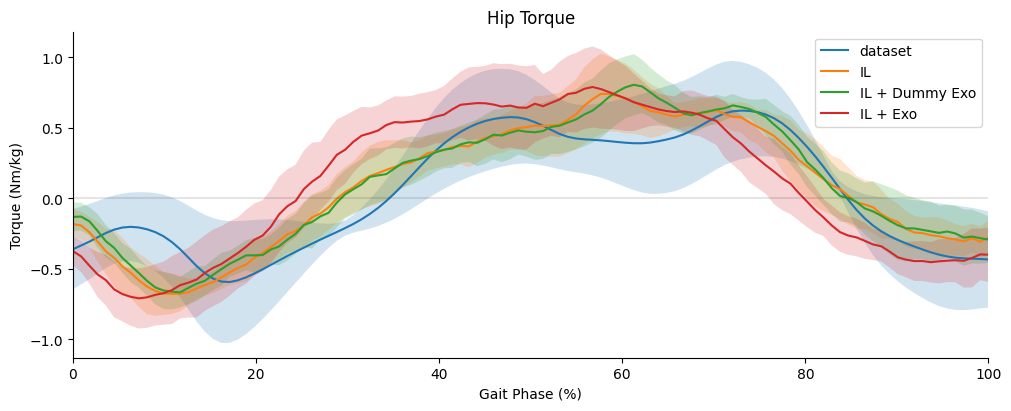

In [142]:
data_dict = {
    'dataset': smooth_2d(dataset_hip_torque, window_size=window_size)/mass,
    'IL': smooth_2d(trained_hip_torque, window_size=window_size)/mass,
    'IL + Dummy Exo': smooth_2d(dummy_hip_torque, window_size=window_size)/mass,
    'IL + Exo': smooth_2d(exo_hip_torque, window_size=window_size)/mass,
}
plot_gait(data_dict, mean_length, ylabel='Torque (Nm/kg)', title='Hip Torque', alpha=0.2, save=True)

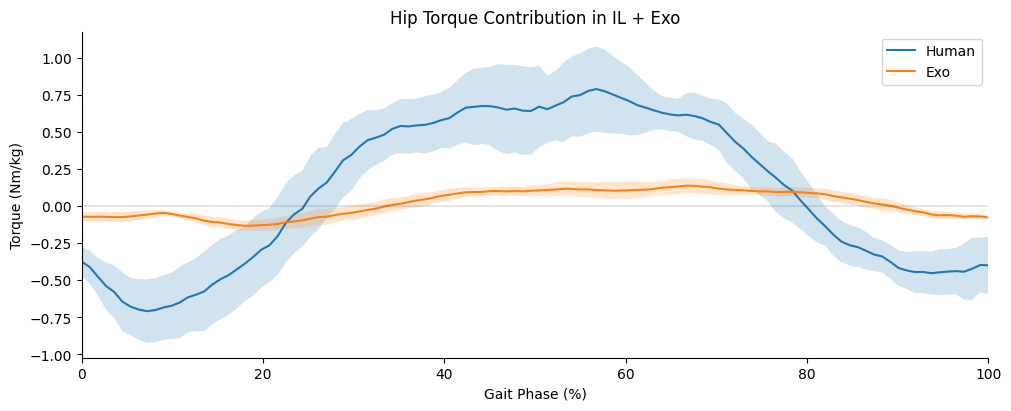

In [143]:
data_dict = {
    'Human': smooth_2d(exo_hip_torque, window_size=window_size)/mass,
    'Exo': smooth_2d(exo_torque, window_size=window_size)/mass,
}
plot_gait(data_dict, mean_length, ylabel='Torque (Nm/kg)', title='Hip Torque Contribution in IL + Exo', alpha=0.2, save=True)

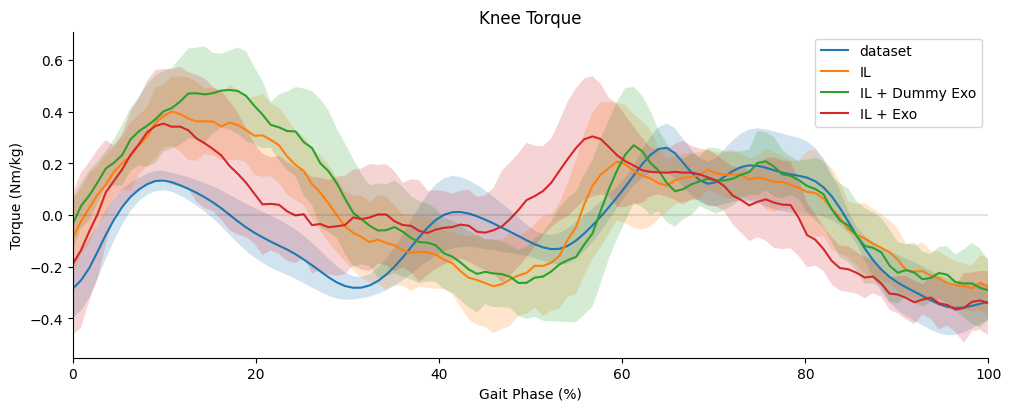

In [144]:
data_dict = {
    'dataset': smooth_2d(dataset_knee_torque, window_size=window_size)/mass,
    'IL': smooth_2d(trained_knee_torque, window_size=window_size)/mass,
    'IL + Dummy Exo': smooth_2d(dummy_knee_torque, window_size=window_size)/mass,
    'IL + Exo': smooth_2d(exo_knee_torque, window_size=window_size)/mass,
}
plot_gait(data_dict, mean_length, ylabel='Torque (Nm/kg)', title='Knee Torque', alpha=0.2, save=True)

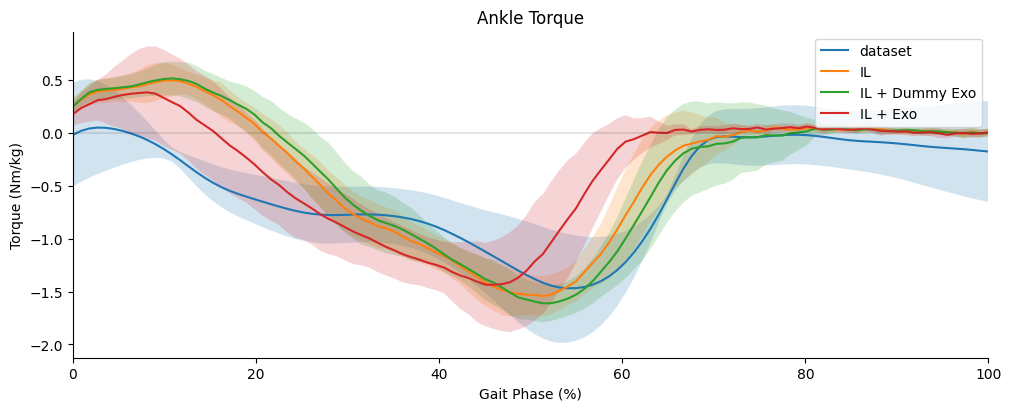

In [145]:
data_dict = {
    'dataset': smooth_2d(dataset_ankle_torque, window_size=window_size)/mass,
    'IL': smooth_2d(trained_ankle_torque, window_size=window_size)/mass,
    'IL + Dummy Exo': smooth_2d(dummy_ankle_torque, window_size=window_size)/mass,
    'IL + Exo': smooth_2d(exo_ankle_torque, window_size=window_size)/mass,
}
plot_gait(data_dict, mean_length, ylabel='Torque (Nm/kg)', title='Ankle Torque', alpha=0.2, save=True)

## Plot GRF

### GRFs comes in 3 components (x y z), compute the magnitude with 2 norm 

In [125]:
def process_grf(grfs):
    processed_grfs = np.swapaxes(grfs, 0, 1)
    processed_grfs = np.swapaxes(processed_grfs, 1, 2)
    processed_grfs = LA.norm(processed_grfs, ord=2, axis=2)
    return processed_grfs

In [126]:
dataset_grfs = process_grf(dataset_interpolated_cycles[-3:])
trained_grfs = process_grf(trained_interpolated_cycles[-3:])
dummy_grfs = process_grf(dummy_interpolated_cycles[-3:])
exo_grfs = process_grf(exo_interpolated_cycles[-4:-1])

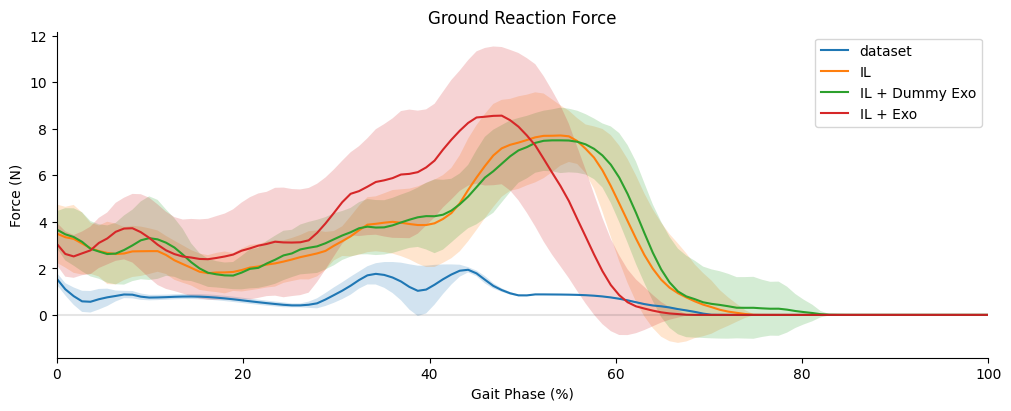

In [153]:
data_dict = {
    'dataset': smooth_2d(dataset_grfs, window_size=window_size)/mass,
    'IL': smooth_2d(trained_grfs, window_size=window_size)/mass,
    'IL + Dummy Exo': smooth_2d(dummy_grfs, window_size=window_size)/mass,
    'IL + Exo': smooth_2d(exo_grfs, window_size=window_size)/mass,
}
plot_gait(data_dict, mean_length, ylabel='Force (N)', title='Ground Reaction Force', alpha=0.2, save=True)

### Plot GRF in the scale of body weight

In [128]:
weight = mass * 9.8

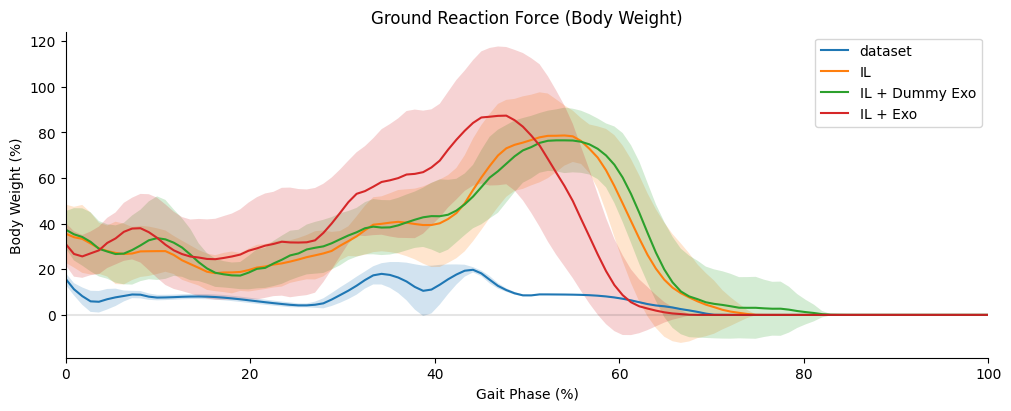

In [152]:
data_dict = {
    'dataset': smooth_2d(dataset_grfs*100/weight, window_size=window_size),
    'IL': smooth_2d(trained_grfs*100/weight, window_size=window_size),
    'IL + Dummy Exo': smooth_2d(dummy_grfs*100/weight, window_size=window_size),
    'IL + Exo': smooth_2d(exo_grfs*100/weight, window_size=window_size),
}
plot_gait(data_dict, mean_length, ylabel='Body Weight (%)', title='Ground Reaction Force (Body Weight)', alpha=0.2, save=True)

## plot Power

In [148]:
dataset_hip_velocity = dataset_interpolated_cycles[3]
dataset_knee_velocity = dataset_interpolated_cycles[4]
dataset_ankle_velocity = dataset_interpolated_cycles[5]

trained_hip_velocity = trained_interpolated_cycles[3]
trained_knee_velocity = trained_interpolated_cycles[4]
trained_ankle_velocity = trained_interpolated_cycles[5]

dummy_hip_velocity = dummy_interpolated_cycles[3]
dummy_knee_velocity = dummy_interpolated_cycles[4]
dummy_ankle_velocity = dummy_interpolated_cycles[5]

exo_hip_velocity = exo_interpolated_cycles[3]
exo_knee_velocity = exo_interpolated_cycles[4]
exo_ankle_velocity = exo_interpolated_cycles[5]

In [132]:
dataset_hip_power = np.multiply(dataset_hip_torque, dataset_hip_velocity)
dataset_knee_power = np.multiply(dataset_knee_torque, dataset_knee_velocity)
dataset_ankle_power = np.multiply(dataset_ankle_torque, dataset_ankle_velocity)

trained_hip_power = np.multiply(trained_hip_torque, trained_hip_velocity)
trained_knee_power = np.multiply(trained_knee_torque, trained_knee_velocity)
trained_ankle_power = np.multiply(trained_ankle_torque, trained_ankle_velocity)

dummy_hip_power = np.multiply(dummy_hip_torque, dummy_hip_velocity)
dummy_knee_power = np.multiply(dummy_knee_torque, dummy_knee_velocity)
dummy_ankle_power = np.multiply(dummy_ankle_torque, dummy_ankle_velocity)

exo_hip_power = np.multiply(exo_hip_torque, exo_hip_velocity)
exo_knee_power = np.multiply(exo_knee_torque, exo_knee_velocity)
exo_ankle_power = np.multiply(exo_ankle_torque, exo_ankle_velocity)

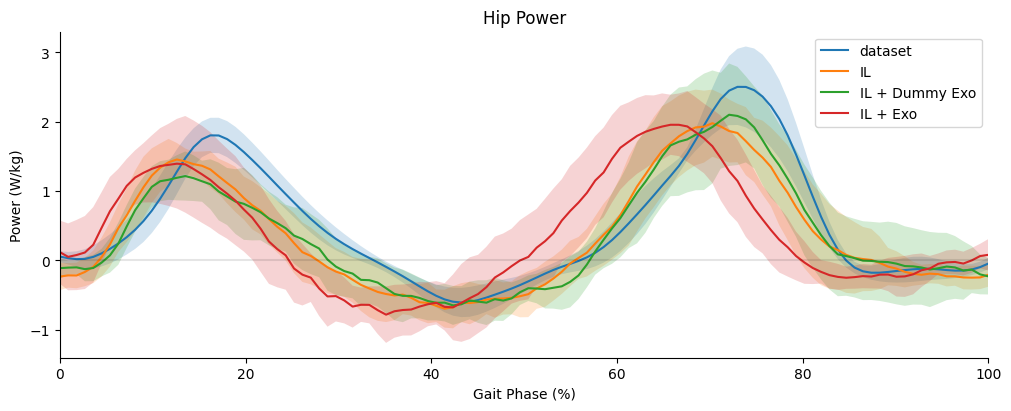

In [149]:
data_dict = {
    'dataset': smooth_2d(dataset_hip_power, window_size=window_size)/mass,
    'IL': smooth_2d(trained_hip_power, window_size=window_size)/mass,
    'IL + Dummy Exo': smooth_2d(dummy_hip_power, window_size=window_size)/mass,
    'IL + Exo': smooth_2d(exo_hip_power, window_size=window_size)/mass,
}
plot_gait(data_dict, mean_length, ylabel='Power (W/kg)', title='Hip Power', alpha=0.2, save=True)

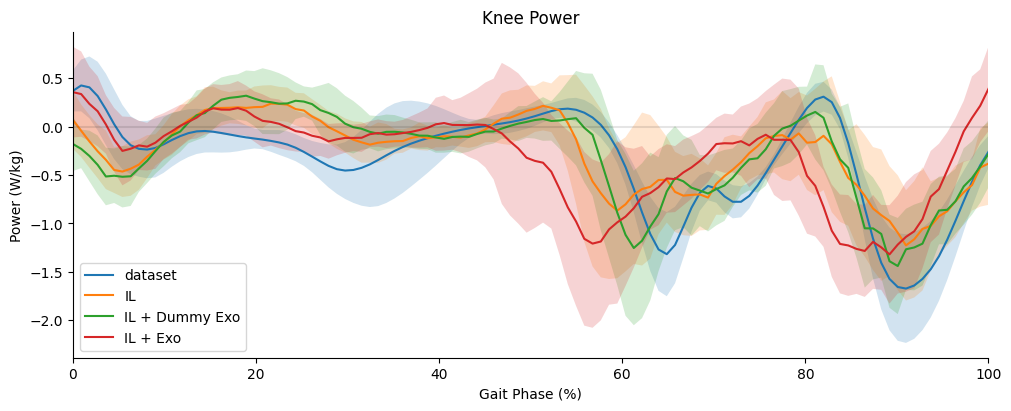

In [150]:
data_dict = {
    'dataset': smooth_2d(dataset_knee_power, window_size=window_size)/mass,
    'IL': smooth_2d(trained_knee_power, window_size=window_size)/mass,
    'IL + Dummy Exo': smooth_2d(dummy_knee_power, window_size=window_size)/mass,
    'IL + Exo': smooth_2d(exo_knee_power, window_size=window_size)/mass,
}
plot_gait(data_dict, mean_length, ylabel='Power (W/kg)', title='Knee Power', alpha=0.2, save=True)

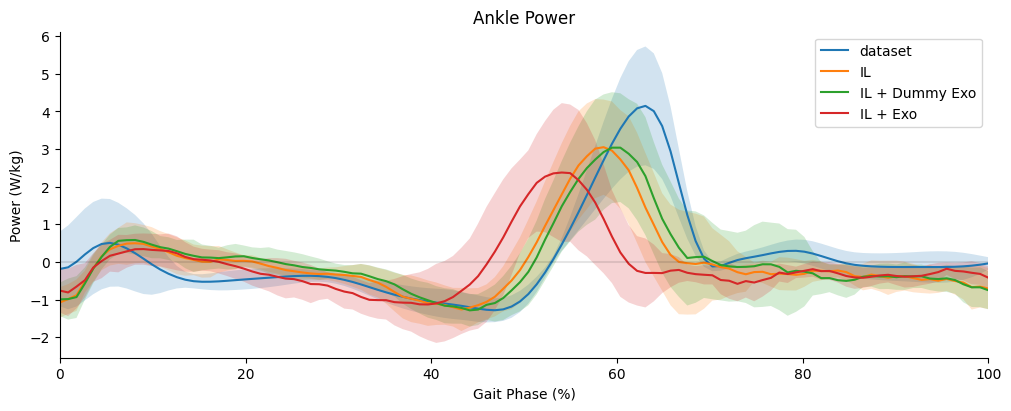

In [151]:
data_dict = {
    'dataset': smooth_2d(dataset_ankle_power, window_size=window_size)/mass,
    'IL': smooth_2d(trained_ankle_power, window_size=window_size)/mass,
    'IL + Dummy Exo': smooth_2d(dummy_ankle_power, window_size=window_size)/mass,
    'IL + Exo': smooth_2d(exo_ankle_power, window_size=window_size)/mass,
}
plot_gait(data_dict, mean_length, ylabel='Power (W/kg)', title='Ankle Power', alpha=0.2, save=True)